# Deep Convolutional GAN - MNIST

In [1]:
import os
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

In [2]:
torch.__version__

'1.11.0'

In [3]:
os.makedirs("samples", exist_ok=True)

## Hyper Parameters

In [4]:
epoch =0  # "epoch to start training from"
n_epochs = 100 # "number of epochs of training"
batch_size = 64 # "size of the batches"
lr = 0.0002 # "adam: learning rate"
b1 = 0.5 # "adam: decay of first order momentum of gradient"
b2 = 0.999 # "adam: decay of first order momentum of gradient"
n_cpu = 8 # "number of cpu threads to use during batch generation"
img_height = 32 # "size of image height"
img_width = 32 # "size of image width"
channels = 1 # "number of image channels"
z_dim = 100 # "dim of latent z"
sample_interval = 1 # "interval between sampling of images from generators"

## Train Setting

In [5]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# imgage size
img_shape = (channels, img_width, img_height)
img_dim = img_width * img_height 

# MNIST Dataset
transform = transforms.Compose([
    transforms.Resize(img_width),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root='../mnist_data/', train=True, transform=transform, download=True)
# test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    num_workers=n_cpu,
    shuffle=True
)

## Generator

In [6]:
class Generator(nn.Module):
    def __init__(self, input_dim, img_size, channels):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(input_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

## Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self, img_size, channels):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        ds_size = img_size // 2 ** 4
        self.model = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
            nn.Flatten(),
            nn.Linear(128 * ds_size ** 2, 1)
        )

    def forward(self, img):
        return self.model(img)

In [8]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [9]:
# build network
generator = Generator(input_dim=z_dim, img_size=img_width, channels=channels).to(device)
discriminator = Discriminator(img_size=img_width, channels=channels).to(device)

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# loss
adversarial_loss = nn.BCEWithLogitsLoss().to(device)
# adversarial_loss = nn.BCELoss().to(device)
    
# optimizer
G_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
D_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

## Generator Loss

#### generator loss
1. Generate Random noise z

2. Generator makes fake image using noise z

3. Discriminator evaluate whether this image is fake or real

4. Calculate generator loss

In [10]:
def generator_loss(generator):
    z = torch.normal(mean=torch.zeros((batch_size, z_dim)), std=torch.ones((batch_size, z_dim))).to(device)
    valid = torch.ones(batch_size, 1).to(device)
    
    # Generator loss
    fake_G = generator(z)
    pred_fake = discriminator(fake_G)
    G_loss = adversarial_loss(pred_fake, valid)
    
    return G_loss

## Discriminator Loss

#### real Loss
1. Discriminator evaluate whether real image is fake or real

2. Calculate fake loss


#### fake Loss
1. Generator makes fake image using Random noise z

2. Discriminator evaluate whether this fake image is fake or real

3. Calculate fake loss

In [11]:
def discriminator_loss(discriminator, real_imgs):
    valid = torch.ones(real_imgs.size(0), 1).to(device)
    fake = torch.zeros(real_imgs.size(0), 1).to(device)
    
    # real Loss
    pred_real = discriminator(real_imgs)
    D_real_loss = adversarial_loss(pred_real, valid)

    # fake Loss
    z = torch.normal(mean=torch.zeros((real_imgs.size(0), z_dim)), std=torch.ones((real_imgs.size(0), z_dim))).to(device)

    fake_G = generator(z)
    pred_fake = discriminator(fake_G)
    D_fake_loss = adversarial_loss(pred_fake, fake)
    
    return  0.5 * (D_real_loss + D_fake_loss)

## Train

#### Training Process
1. Train Generator
2. Train Discriminator

In [12]:
for epoch in range(epoch, n_epochs):
    for i, (imgs, _) in enumerate(train_loader):
            
        # Configure input
        real_imgs = imgs.to(device)

        # ------------------
        #  Train Generators
        # ------------------
        G_optimizer.zero_grad()
        
        G_loss = generator_loss(generator) 
        G_loss.backward()
        G_optimizer.step()
    
        # ---------------------
        #  Train Discriminator
        # ---------------------
        D_optimizer.zero_grad()

        D_loss = discriminator_loss(discriminator, real_imgs)
        D_loss.backward()
        D_optimizer.step()
        
        if i % 100 == 0:
            sys.stdout.write(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]\n"
                % (epoch, n_epochs, i, len(train_loader), D_loss.item(), G_loss.item())
            )
            
            
    # If at sample interval save image
    if epoch % sample_interval == 0:
        with torch.no_grad():
            test_z = torch.randn(100, z_dim).to(device)
            generated = generator(test_z)

            save_image(generated, './samples/sample_' + str(epoch) + '.png', nrow=10)

[Epoch 0/100] [Batch 0/938] [D loss: 0.693176] [G loss: 0.696849]
[Epoch 0/100] [Batch 100/938] [D loss: 0.696671] [G loss: 0.707305]
[Epoch 0/100] [Batch 200/938] [D loss: 0.690401] [G loss: 0.708496]
[Epoch 0/100] [Batch 300/938] [D loss: 0.693354] [G loss: 0.689693]
[Epoch 0/100] [Batch 400/938] [D loss: 0.692557] [G loss: 0.690282]
[Epoch 0/100] [Batch 500/938] [D loss: 0.689061] [G loss: 0.682703]
[Epoch 0/100] [Batch 600/938] [D loss: 0.692834] [G loss: 0.694504]
[Epoch 0/100] [Batch 700/938] [D loss: 0.690393] [G loss: 0.687413]
[Epoch 0/100] [Batch 800/938] [D loss: 0.689347] [G loss: 0.685313]
[Epoch 0/100] [Batch 900/938] [D loss: 0.692969] [G loss: 0.687073]
[Epoch 1/100] [Batch 0/938] [D loss: 0.689937] [G loss: 0.695934]
[Epoch 1/100] [Batch 100/938] [D loss: 0.695472] [G loss: 0.691809]
[Epoch 1/100] [Batch 200/938] [D loss: 0.693029] [G loss: 0.692804]
[Epoch 1/100] [Batch 300/938] [D loss: 0.688761] [G loss: 0.714044]
[Epoch 1/100] [Batch 400/938] [D loss: 0.692541] [G 

KeyboardInterrupt: 

### Evaluate Generator's fake Image

In [17]:
with torch.no_grad():
    test_z = torch.randn(100, z_dim).to(device)
    generated = generator(test_z)
    save_image(generated, './samples/sample.png', nrow=10)

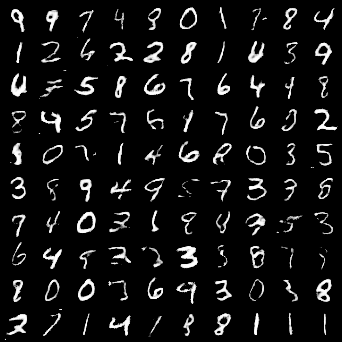

In [18]:
from PIL import Image

Image.open('./samples/sample.png')